# Previsão de Vendas Mercado
#### Os objetivos com este Dataset são: 
* Processar os Dados
* Exploração dos Dados
* Verificar se a dados faltantes
* Substituição de Valores
* Matrix
* Treinar o Modelo

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
%matplotlib inline
warnings.filterwarnings('ignore')

## Dataset

In [2]:
df = pd.read_csv('Train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Processamento dos Dados

In [4]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
cat_col = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        cat_col.append(x)
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [6]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')
cat_col

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [7]:
for col in cat_col:
    print(col)
    print(df[col].value_counts())
    print()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int6

### Verificando Valores Faltantes

In [8]:
item_weight_mean = df.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
item_weight_mean 

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [9]:
miss_bool = df['Item_Weight'].isnull()
miss_bool

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Item_Weight, Length: 8523, dtype: bool

In [10]:
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean:
            df['Item_Weight'][i] = item_weight_mean.loc[item]['Item_Weight']
        else:
            df['Item_Weight'][i] = np.mean(df['Item_Weight'])

In [11]:
df['Item_Weight'].isnull().sum()

0

In [12]:
outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


### Substituição de valores zeros por Mean Value

In [13]:
miss_bool = df['Outlet_Size'].isnull()
df.loc[miss_bool, 'Outlet_Size'] = df.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [14]:
df['Outlet_Size'].isnull().sum()

0

In [15]:
sum(df['Item_Visibility']==0)

526

In [16]:
df.loc[:, 'Item_Visibility'].replace([0], [df['Item_Visibility'].mean()], inplace=True)

In [17]:
sum(df['Item_Visibility']==0)

0

### Soma dos Item Fat Content (LF, low fat, Low Fat) 

In [18]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular','low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Criando novos Atributos para Indicação de Items (FD,DR,NC)

In [19]:
df['New_Item_Type'] = df['Item_Identifier'].apply(lambda x: x[:2])
df['New_Item_Type']

0       FD
1       DR
2       FD
3       FD
4       NC
        ..
8518    FD
8519    FD
8520    NC
8521    FD
8522    DR
Name: New_Item_Type, Length: 8523, dtype: object

In [20]:
df['New_Item_Type'].value_counts()

FD    6125
NC    1599
DR     799
Name: New_Item_Type, dtype: int64

In [21]:
df['New_Item_Type'] = df['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
df['New_Item_Type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: New_Item_Type, dtype: int64

In [22]:
df.loc[df['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
df['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

### Criando novos atributos para (Outlet_Establishment_Year)

In [23]:
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']

In [24]:
df['Outlet_Years']

0       14
1        4
2       14
3       15
4       26
        ..
8518    26
8519    11
8520     9
8521     4
8522    16
Name: Outlet_Years, Length: 8523, dtype: int64

### Exploração dos Dados

In [25]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_Item_Type,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


* Peso do Item (Item_Weight)

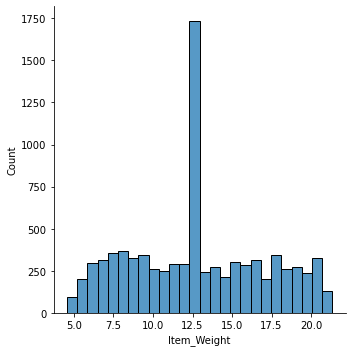

In [26]:
sns.displot(df['Item_Weight'])

* Visibilidade (Item Visibility)

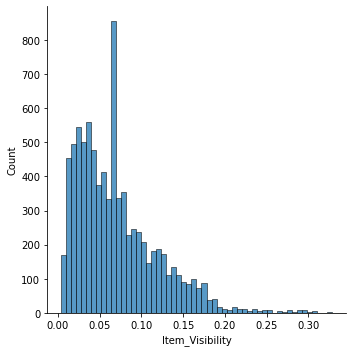

In [27]:
sns.displot(df['Item_Visibility'])

* Item_MRP

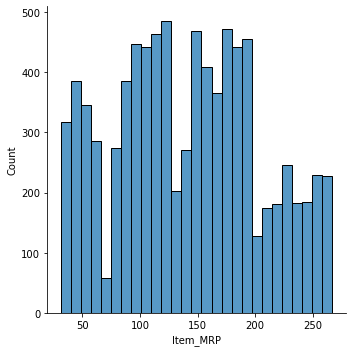

In [28]:
sns.displot(df['Item_MRP'])

* Item Outlet Sales

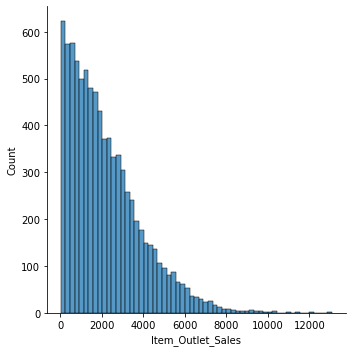

In [29]:
sns.displot(df['Item_Outlet_Sales'])

In [30]:
df['Item_Outlet_Sales'] = np.log(df['Item_Outlet_Sales'])

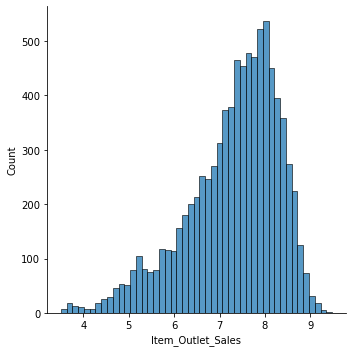

In [31]:
sns.displot(df['Item_Outlet_Sales'])

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

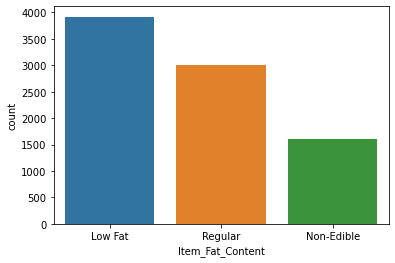

In [32]:
sns.countplot(df['Item_Fat_Content'])

[Text(0, 0, 'Dairy'),
 Text(1, 0, 'Soft Drinks'),
 Text(2, 0, 'Meat'),
 Text(3, 0, 'Fruits and Vegetables'),
 Text(4, 0, 'Household'),
 Text(5, 0, 'Baking Goods'),
 Text(6, 0, 'Snack Foods'),
 Text(7, 0, 'Frozen Foods'),
 Text(8, 0, 'Breakfast'),
 Text(9, 0, 'Health and Hygiene'),
 Text(10, 0, 'Hard Drinks'),
 Text(11, 0, 'Canned'),
 Text(12, 0, 'Breads'),
 Text(13, 0, 'Starchy Foods'),
 Text(14, 0, 'Others'),
 Text(15, 0, 'Seafood')]

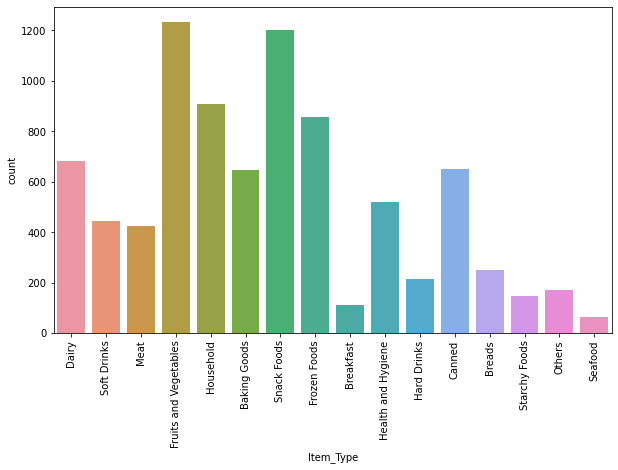

In [33]:
l = list (df['Item_Type'].unique())
plt.figure(figsize=[10,6])
chart = sns.countplot(df['Item_Type'])
chart.set_xticklabels(labels=l, rotation=90)

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

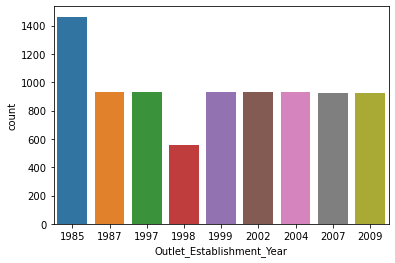

In [34]:
sns.countplot(df['Outlet_Establishment_Year'])

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

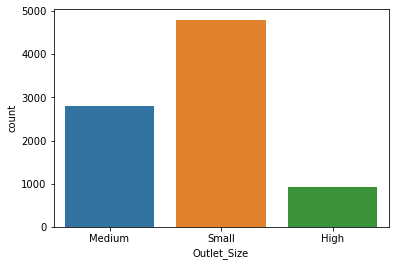

In [35]:
sns.countplot(df['Outlet_Size'])

[Text(0, 0, 'Supermarket Type1'),
 Text(1, 0, 'Supermarket Type2'),
 Text(2, 0, 'Grocery Store'),
 Text(3, 0, 'Supermarket Type3')]

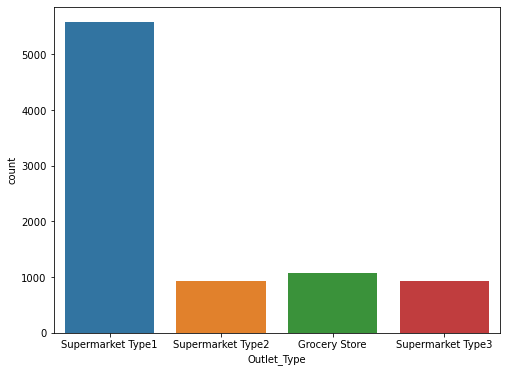

In [36]:
l = list (df['Outlet_Type'].unique())
plt.figure(figsize=[8,6])
chart = sns.countplot(df['Outlet_Type'])
chart.set_xticklabels(labels=l)

### Matrix

<AxesSubplot:>

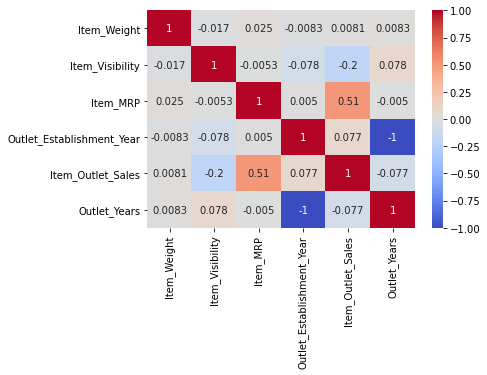

In [37]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [38]:
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type']
for col in cat_col:
    df[col] = le.fit_transform(df[col])

In [39]:
df = pd.get_dummies(df, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'])
df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Years,Outlet,...,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,New_Item_Type_0,New_Item_Type_1,New_Item_Type_2
0,FDA15,9.30,0.016047,4,249.8092,OUT049,1999,8.225540,14,9,...,1,0,0,0,1,0,0,0,1,0
1,DRC01,5.92,0.019278,14,48.2692,OUT018,2009,6.094524,4,3,...,0,0,1,0,0,1,0,1,0,0
2,FDN15,17.50,0.016760,10,141.6180,OUT049,1999,7.648392,14,9,...,1,0,0,0,1,0,0,0,1,0
3,FDX07,19.20,0.066132,6,182.0950,OUT010,1998,6.596300,15,0,...,0,0,1,1,0,0,0,0,1,0
4,NCD19,8.93,0.066132,9,53.8614,OUT013,1987,6.902446,26,1,...,0,0,1,0,1,0,0,0,0,1


## Input Split

In [40]:
X = df.drop(columns=['Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

## Model Training

In [41]:
def train(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print("Resultados do Modelo")
    print("MSE:", mean_squared_error(y,pred))
    print("CV Score:", cv_score)

Resultados do Modelo
MSE: 0.28903721144586286
CV Score: 0.2904753695753318


<AxesSubplot:title={'center':'Modelo de Coeficiente (Regressão Linear)'}>

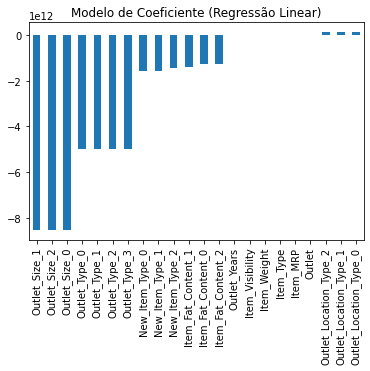

In [42]:
model = LinearRegression(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Modelo de Coeficiente (Regressão Linear)")

Resultados do Modelo
MSE: 0.4295279502274513
CV Score: 0.4304302638256898


<AxesSubplot:title={'center':'Modelo de Coeficiente (Ridge)'}>

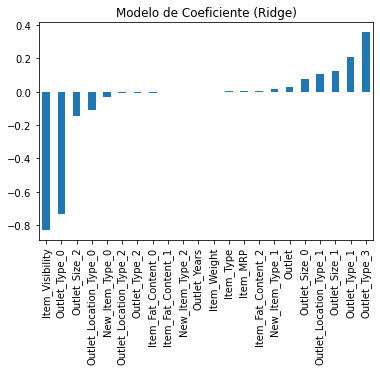

In [43]:
model = Ridge(normalize=True)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Modelo de Coeficiente (Ridge)")

Resultados do Modelo
MSE: 0.7659479715024338
CV Score: 0.7661586116899373


<AxesSubplot:title={'center':'Modelo de Coeficiente (Lasso)'}>

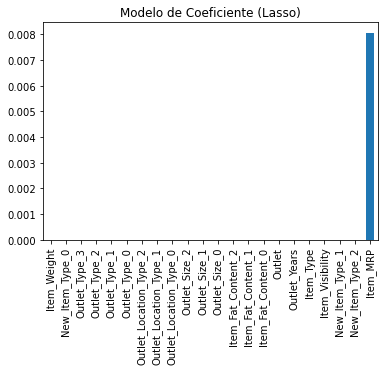

In [44]:
model = Lasso(normalize=False)
train(model, X, y)
coef = pd.Series(model.coef_, X.columns).sort_values()
coef.plot(kind='bar', title="Modelo de Coeficiente (Lasso)")

Resultados do Modelo
MSE: 0.0
CV Score: 0.576626132047199


<AxesSubplot:title={'center':'Relevância dos Features'}>

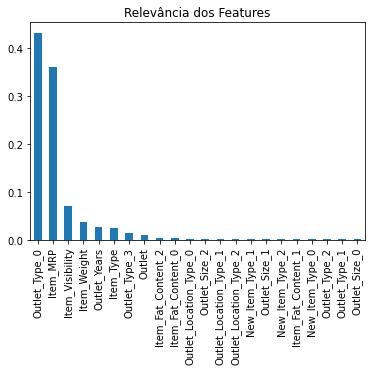

In [45]:
model = DecisionTreeRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Relevância dos Features")

Resultados do Modelo
MSE: 0.04233165452740459
CV Score: 0.3105665002274479


<AxesSubplot:title={'center':'Modelo de Coeficiente'}>

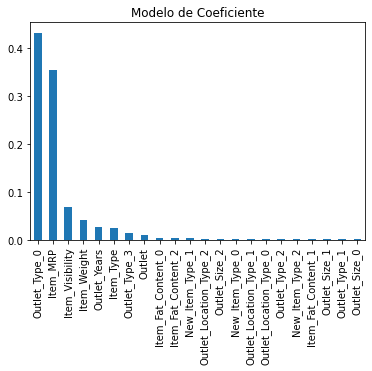

In [47]:
model = RandomForestRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Modelo de Coeficiente")

Resultados do Modelo
MSE: 1.0235479500914401e-28
CV Score: 0.3326271333401988


<AxesSubplot:title={'center':'Modelo de Coeficiente'}>

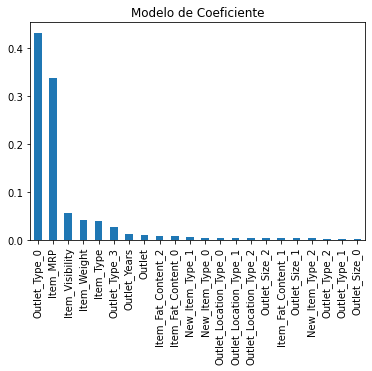

In [50]:
model = ExtraTreesRegressor()
train(model, X, y)
coef = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
coef.plot(kind='bar', title="Modelo de Coeficiente")